# Product Insigh Analyst Case Study #

We have two similar systems in Xero, full BAS and simpler BAS, for users to fulfill their compliance needs with the ATO. Attached are some extracts of times when each of the reports were being run by our users (simplebas.csv and fullbas.csv), and some metadata about the organisations (orgcard.csv).



Limit your analysis to active, paying organisations (orgs).

In this scenario, you are looking to present insights to the product manager of BAS at Xero. They would like to see:
1. an overview of how and when users interact with each system;
2. a comparison in terms of usage of each system;
3. a view of seasonality that could inform the need to increase compute capacity;
4. your recommendation on what the best time of month would be to have a two hour
outage window for each system.

Here are some key data points to include in your data story:
- What month saw the most report runs?
- How many orgs ran both reports?
- How many users have used either report?
- How many users have run reports for multiple organisations?
- Which pricing plans are the most popular amongst organisations using BAS?

### Note: 
Import variable: time stamps, userid, orgid, productopion, payingflag, runtime.

### Main Idea:

We can build a dashboard that performs time series analyses on FullBAS, and SimpleBAS data. \
First, we can create a plot of general system usage (user/org agnostic) between Full and Simple, 2 overlaying histograms. \
Then, decompose the above to filter for organizations. (we might even be able to do some kind of orgnisation classification here base on usage frequency) \
Hone into FullBAS, weigh the histograms by runtime to identify bottle necks/choking period to determine the need for compute capacity, and spot offtime for best outage window. 



We can implement some basic filters:
1. time
2. paying flags. 
3. productoption
4. orgstatus

## Assumptions
1. Timezone is simple BAS is Australia/Sydney timezone UTC+11
2. All users in simple BAS belong to Orgs that are paying Orgs

In [201]:
import pandas as pd
from datetime import date, datetime,  timedelta
import copy


from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
import dash_daq as daq

from dash.dependencies import Input, Output
import plotly.express as px

pd.options.plotting.backend = "plotly"

In [ ]:
orgdetails = pd.read_csv('data/orgcard.csv')
orgdetails['organisationid'] =orgdetails['organisationid'].str.lower()


fullbas = pd.read_csv('data/fullbas.csv')
fullbas['datetime'] = fullbas['datestring']+' '+fullbas['timestring']
fullbas['datetime'] = fullbas['datetime'].astype('datetime64[s]').dt.tz_localize('Australia/Sydney',ambiguous=True)

simplebas = pd.read_csv('data/simplebas.csv')
simplebas['datetime'] = simplebas['datetime'].astype('datetime64[s]')


In [ ]:
simpledf=simplebas.groupby([simplebas['datetime'].dt.date]).size().reset_index(name='count')
fulldf = fullbas.groupby([fullbas['datetime'].dt.date]).size().reset_index(name='count')


In [197]:
def filter_by_time(df, start_date, end_date):

    dff = df[
        (df["datetime"].dt.date > datetime.strptime(start_date, "%Y-%m-%d").date())
        & (df["datetime"].dt.date < datetime.strptime(end_date, "%Y-%m-%d").date())
    ]
    return dff

def filter_by_payingflag(df, paying_status):
    return df[df['payingflag'].isin(list(map(int, paying_status)))]

def filter_by_status(df, status):
    return df[df['organisationstatus'].isin(list(map(int, status)))]



In [198]:
simpledf=simplebas.groupby([simplebas['datetime'].dt.date]).size().reset_index(name='count')
fulldf = fullbas.groupby([fullbas['datetime'].dt.date]).size().reset_index(name='count')

In [208]:
layout = dict(
    autosize=True,
    automargin=True,
    margin=dict(l=30, r=30, b=20, t=40),
    hovermode="closest",
    plot_bgcolor="#F9F9F9",
    paper_bgcolor="#F9F9F9",
    legend=dict(font=dict(size=10), orientation="h"),
)

app = JupyterDash(__name__)
app.layout = html.Div([
    dcc.DatePickerRange(
                    id="date_picker",
                    start_date = '2016-10-01',
                    end_date=date.today(),
                    display_format='MMM Do, YY',
                    start_date_placeholder_text='MMM Do, YY'
                ),
    dcc.Checklist(
                    id="payment_status",
                    options={
                            '1': 'Paying',
                            '0': 'Non-Paying',
                    },
                    value=['1']
                    ),
     daq.BooleanSwitch(
                        id='dailyweeklytoggle',
                        on=True,
                        label="Daily/Weekly",
                        labelPosition="bottom",
                        style= {'width': 'fit-content'}
                        ),
    dcc.Graph(id="usage_graph"),
])
@app.callback(
    Output("usage_graph", "figure"), 
    Input("date_picker", "start_date"),
    Input("date_picker", "end_date"),
    Input("payment_status", "value"),
    Input("dailyweeklytoggle","on")
    )
def update_usage_graph(start_date, end_date, payment_status, dailyweeklytoggle): 
    
    layout_aggregate = copy.deepcopy(layout)

    fullbas_w_org = pd.merge(fullbas, orgdetails, left_on='orgid', right_on='organisationid', how="inner")
    fullbas_w_org = filter_by_payingflag(fullbas_w_org,payment_status)

    # simpledf=simplebas.groupby([simplebas['datetime'].dt.date]).size().reset_index(name='count')
    # fulldf = fullbas_w_org.groupby([fullbas_w_org['datetime'].dt.date]).size().reset_index(name='count')
    if dailyweeklytoggle:
        simpledf = simplebas.groupby(pd.Grouper(freq='D', key='datetime')).size().reset_index(name='count')
        fulldf = fullbas_w_org.groupby(pd.Grouper(freq='D', key='datetime')).size().reset_index(name='count')
    else:

        simpledf = simplebas.groupby(pd.Grouper(freq='W', key='datetime')).size().reset_index(name='count')
        fulldf = fullbas_w_org.groupby(pd.Grouper(freq='W', key='datetime')).size().reset_index(name='count')

    simpledff = filter_by_time(simpledf, start_date, end_date)
    fulldff = filter_by_time(fulldf, start_date, end_date)
    
    data = [
            dict(
                type="line",
                name="Full",
                x=fulldff['datetime'],
                y=fulldff['count'],
                line=dict(shape="spline", smoothing=2, width=1, ),
            ),
            dict(
                type="line",
                name="Simple",
                x=simpledff['datetime'],
                y=simpledff['count'],
                line=dict(shape="spline", smoothing=2, width=1),
            ),
            ]
    figure = dict(data=data, layout=layout_aggregate)
    return figure
app.run_server(mode='inline', port=8050, debug=True)

In [ ]:
def isOneToOne(df, col1, col2):
    first = df.drop_duplicates([col1, col2]).groupby(col1)[col2].count().max()
    second = df.drop_duplicates([col1, col2]).groupby(col2)[col1].count().max()
    return first + second == 2


In [99]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [196]:
df = fullbas.groupby(pd.Grouper(freq='W', key='datetime')).size().reset_index(name='count')


df2 = simplebas.groupby(pd.Grouper(freq='W', key='datetime')).size().reset_index(name='count')

start=fullbas['datetime'].min()
end=fullbas['datetime'].max()
n = (end.date()-start.date())

simpledf = simplebas.groupby(pd.Grouper(freq='W', key='datetime')).size().reset_index(name='count')
    

simpledf['datetime'].dt.date>datetime.strptime('2018-10-10', "%Y-%m-%d").date()


0      False
1      False
2      False
3      False
4      False
       ...  
125     True
126     True
127     True
128     True
129     True
Name: datetime, Length: 130, dtype: bool

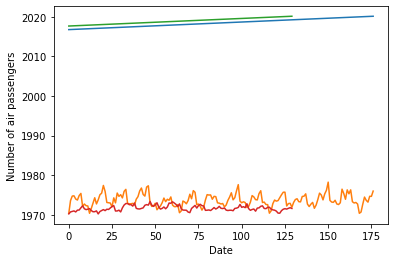